 # Building an AI Agent to run Machine Learning Models using Langgraph

# Summary

The below code uses a llama3.2:1b model with Langgraph to train and call a linear regression model to perform point prediction and understand the features.

A brief explanation of the tools used:
1. Ollama (using llama3.2:1b) is a local on-device program that lets you host LLMs on your device. I called this library using the LLM llamma3.2:1b.
2. Langgraph is a library that lets you structure LLMs as nodes in a graph. This allows your to orchestrate and coordinate LLMs for your purposes. These LLMs can be given tools to

In this project I wanted to do the following:
1. Create a fake dataset that can be used for supervised learning, in this case linear regression and save it to a csv file.
2. Create functions for training the model using the csv file, provide a point prediction if values for the input features are provided, recall the coefficients of the model that indicates the influence of the features against sales and summarise the above for a sales team to decide what to do next.
3. Have an LLM as a interface to do all of the points in step 2 by defining the functions as tools for the LLM to use.

For this I wanted to create an architecture that had a "Data Scientist" tasked with the modelling activities, and an "Analyst" which takes the output of the "Data Scientist" LLM to summarise. To achieve this I created a continous loop between the LLM and the tools, where the loop will only be broken if the LLM cannot find a way to call those tools. This will allow me to give multiple instructions to the Data Scientist and have them perform them before summarising. The graph architecture can be found below:

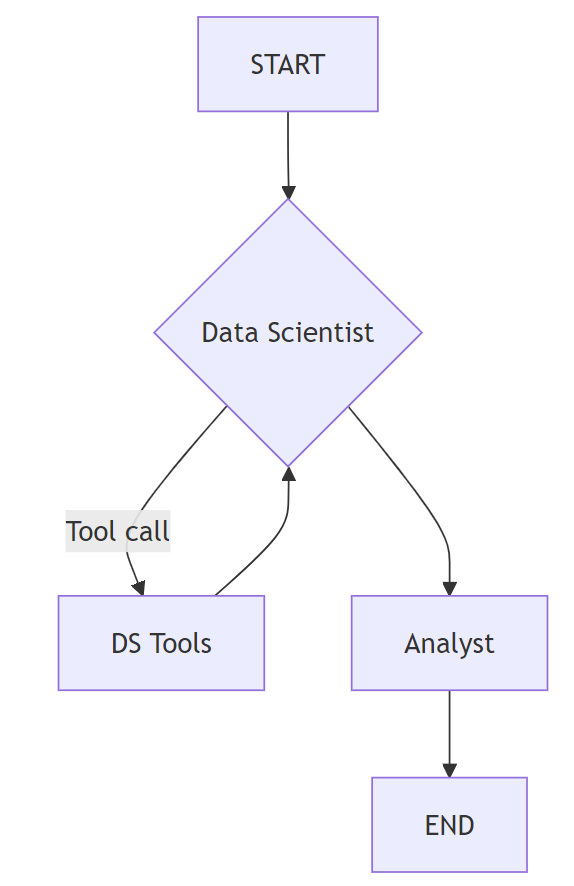

# 1. Import the Ollama model

In [1]:
# Step 2: Instantiate the ChatOllama class
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:1b", temperature=0)

# 2. Create a fake dataset

In [2]:
# # Make a fake dataset

# # Number of data points
# n_samples = 500

# # Generating synthetic data with modified conditions
# advertising_spend = np.random.uniform(5000, 50000, n_samples) # Advertising spend between 5,000 and 50,000
# week_of_campaign = np.random.randint(1, 5, n_samples) # Week of campaign month (1 to 4)
# marketing_channels = np.random.choice(['social_media', 'tv', 'radio'], n_samples) # Randomly chosen marketing channels

# # Modifying base sales to ensure it increases with advertising spend and week of campaign impact
# # More sales should happen in the first week of the month
# base_sales = advertising_spend * 0.08 + (5 - week_of_campaign) * 3000

# # Adding a stronger channel effect to make TV bring in the most sales
# channel_effect = {
#     'social_media': 5000,
#     'tv': 10000,
#     'radio': 6000
# }
# sales = base_sales + np.array([channel_effect[channel] for channel in marketing_channels]) + np.random.normal(0, 1500, n_samples)

# # Creating the DataFrame with 500 rows
# fake_data_500 = pd.DataFrame({
#     'advertising_spend': advertising_spend,
#     'marketing_channel': marketing_channels,
#     'week_of_campaign': week_of_campaign,
#     'sales': sales
# })

# # Display the first few rows of the modified dataset
# fake_data_500.head()

# 3. Build a series of functions and bind them to the LLM

We want to create 3 functions and bind them to the LLM:
1. Normalise and featurise the data, train the regression model.
2. Predict sales volume when providing the features advertising_spend, marketing_channel, week_of_campaign.
3. Provide the coefficients of the model to interpret how changing the features affects the sales volume.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from typing import Union

# Linear Regression Tool Function
class SalesLinearRegression:
    def __init__(self):
        self.model = None
        self.scaler = MinMaxScaler()
        self.feature_names = None

    def normalize_and_train(self, data: pd.DataFrame) -> str:
        # Encoding categorical variable 'marketing_channel'
        data = pd.get_dummies(data, columns=['marketing_channel'], drop_first=True)

        # Extract features and target
        features = data.drop(columns=['Unnamed: 0', 'sales'])
        target = data['sales']
        self.feature_names = features.columns

        # Normalize features
        features_normalized = self.scaler.fit_transform(features)

        # Train Linear Regression Model
        self.model = LinearRegression()
        self.model.fit(features_normalized, target)

        return "Linear regression model trained successfully."

    def predict(self, advertising_spend: float, marketing_channel: str, week_of_campaign: int) -> Union[str, float]:
        if self.model is None:
            return "Error: Model has not been trained yet."

        # Creating input features dataframe for prediction
        features_dict = {
            "advertising_spend": advertising_spend,
            "week_of_campaign": week_of_campaign
        }
        # Adding encoded marketing channel as dummy variables
        for channel in self.feature_names:
            if channel.startswith("marketing_channel_"):
                features_dict[channel] = 1 if channel == f"marketing_channel_{marketing_channel}" else 0

        features_df = pd.DataFrame([features_dict])
        features_normalized = self.scaler.transform(features_df)

        # Predicting the sales
        prediction = self.model.predict(features_normalized)

        return float(prediction[0])

    def interpret_model(self) -> str:
        if self.model is None:
            return "Error: Model has not been trained yet."

        coefs = self.model.coef_
        feature_importance = sorted(zip(self.feature_names, coefs), key=lambda x: abs(x[1]), reverse=True)

        # Create an interpretation of feature impact
        interpretation = "Feature Impact on Sales:\n"
        for feature, coef in feature_importance:
            interpretation += f"{feature}: {coef}\n"

        return interpretation


# Instantiate the SalesLinearRegression tool
sales_lr_tool = SalesLinearRegression()

# Tool Functions for Langgraph
def train_linear_regression_tool(csv_path: str) -> str:
    """ Take a csv file path as an input use that data to train a linear regression model"""
    # Read CSV data
    data = pd.read_csv(csv_path)

    # Train model and return result
    return sales_lr_tool.normalize_and_train(data)

def predict_sales_tool(advertising_spend: float, marketing_channel: str, week_of_campaign: int) -> str:
    """ Take advertising spend, marketing channel and week of campaign and use these as inputs to a linear regression model.
    Output the prediction of sales volume.
    """
    # Predict sales
    return sales_lr_tool.predict(advertising_spend, marketing_channel, week_of_campaign)

def interpret_model_tool() -> str:
    """ Interpret the features of the trained model"""
    # Interpret the trained model
    return sales_lr_tool.interpret_model()

tools = [train_linear_regression_tool, predict_sales_tool, interpret_model_tool]
llm_with_tools = llm.bind_tools([train_linear_regression_tool, predict_sales_tool, interpret_model_tool])

# 4. Check if the functions work

In [4]:
train_linear_regression_tool("fake_data_500.csv")

'Linear regression model trained successfully.'

In [5]:
# Predicting sales
predicted_sales = predict_sales_tool(20000, "social_media", 2)
print(f"Predicted Sales: {predicted_sales}")

Predicted Sales: 15713.335997998473


In [6]:
# Interpreting the model
interpretation = interpret_model_tool()
print(interpretation)

Feature Impact on Sales:
week_of_campaign: -9300.218191357746
marketing_channel_tv: 4101.384413315225
advertising_spend: 3722.602617038881
marketing_channel_social_media: -819.4398712317993



# 5. Build the nodes

Define the system messages for each node, this is the first part of the prompt that is passed to the LLM and tells it how to function

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
data_scientist_sys_msg = SystemMessage(content="You are a data scientist working for a sales company tasked with running a linear regression model on a dataset. Train a linear regression model using the tools available to you and confirm that it has been trained.")
analyst_sys_msg = SystemMessage(content="You are an analyst for a sales company tasked with summarising the following output from a Data Scientist to the sales team.")

# Node
def data_scientist(state: MessagesState):
    # print out in the terminal to show the node is being successfully called
    print("------------------")
    print("DATA SCIENTIST NODE")
    # Add the system message with the message input by the user
    input = [data_scientist_sys_msg] + state["messages"]
    # invoke the LLM with the input
    out = llm_with_tools.invoke(input)
    print("------------------")
    # return the LLM output
    return {"messages": [out]}

def analyst(state: MessagesState):
    # print out in the terminal to show the node is being successfully called
    print("------------------")
    print("ANALYST NODE")
    # Add the system message with the last previous message which is teh output from the Data Scientist node
    input = [analyst_sys_msg] + [str(state["messages"][-1])]
    out = llm.invoke(input)
    # invoke the LLM with the input
    print("------------------")
    # return the LLM output
    return {"messages": [out]}

Define a function that dictates the conditions for calling the tools node or the Analyst node after the Data Scientist has interacted with the users input.

This logic states that if the Data Scientist node realises that a tool can be called from the user input text, it will call the tools node. When there are no more tools identified, it will pass the output to the analyst.

In [8]:
from langgraph.graph.message import AnyMessage
from typing import Any, Literal
from pydantic import BaseModel
from langgraph.graph import StateGraph, MessagesState, START, END

def ds_tools_condition_to_analyst(
    state: Union[list[AnyMessage], dict[str, Any], BaseModel],
) -> Literal["tools", "analyst"]:
    # If a message can be identified, save it to ai_message
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get("messages", [])):
        ai_message = messages[-1]
    elif messages := getattr(state, "messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # If the ai_message had identified a tools call, return the tools node
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    # If there is no tools call, pass the output to the analyst
    return "analyst"

In [9]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
import grandalf

# Initialise Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("data_scientist", data_scientist)
builder.add_node("analyst", analyst)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "data_scientist")

# Create a conditional edge that will route to the tools node if it identifies the need for a tools call, otherwise pass to the analyst node
builder.add_conditional_edges(
    "data_scientist",
    ds_tools_condition_to_analyst,
)

# To make a loop, make an edge between tools and the Data Scientist node to allow the Data Scientist to call the tools node repeatedly if there are 
# more than one identified by the Data Scientist
builder.add_edge("tools", "data_scientist")

# End the graph after the analyst summarises the response
builder.add_edge("analyst", END)

react_graph = builder.compile()

# Show the graph as an ascii file
display(Image(react_graph.get_graph(xray=True).draw_ascii()))
### My local machine poorly prints this out in ascii format, a better graph can be found in the Summary section

FileNotFoundError: No such file or directory: '        +-----------+         
        | __start__ |         
        +-----------+         
              *               
              *               
              *               
     +----------------+       
     | data_scientist |       
     +----------------+       
         .         .          
       ..           ..        
      .               .       
+-------+         +---------+ 
| tools |         | analyst | 
+-------+         +---------+ 
                        *     
                        *     
                        *     
                  +---------+ 
                  | __end__ | 
                  +---------+ '

FileNotFoundError: No such file or directory: '        +-----------+         
        | __start__ |         
        +-----------+         
              *               
              *               
              *               
     +----------------+       
     | data_scientist |       
     +----------------+       
         .         .          
       ..           ..        
      .               .       
+-------+         +---------+ 
| tools |         | analyst | 
+-------+         +---------+ 
                        *     
                        *     
                        *     
                  +---------+ 
                  | __end__ | 
                  +---------+ '

<IPython.core.display.Image object>

# 6. Run the graph to train a linear regression model while explicitly calling out the function

In [10]:
messages = [HumanMessage(content="""Using the train_linear_regression_tool train a linear regression model, the csv input path is 'fake_data_500.csv'""")]

messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

------------------
DATA SCIENTIST NODE
------------------
------------------
DATA SCIENTIST NODE
------------------
------------------
ANALYST NODE
------------------
================================ Human Message =================================

Using the train_linear_regression_tool train a linear regression model, the csv input path is 'fake_data_500.csv'
================================== Ai Message ==================================
Tool Calls:
  train_linear_regression_tool (214da011-dd86-4042-9308-f27becb0bf14)
 Call ID: 214da011-dd86-4042-9308-f27becb0bf14
  Args:
    csv_path: fake_data_500.csv
================================= Tool Message =================================
Name: train_linear_regression_tool

Linear regression model trained successfully.
================================== Ai Message ==================================

I'm glad to inform you that the linear regression model has been trained successfully using the `train_linear_regression_tool` tool. The outpu

# 7. Run the graph to train a regression model while not calling out the function

In [11]:
messages = [HumanMessage(content="""Train a linear regression model, the csv input path is 'fake_data_500.csv'""")]

messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

------------------
DATA SCIENTIST NODE
------------------
------------------
DATA SCIENTIST NODE
------------------
------------------
ANALYST NODE
------------------
================================ Human Message =================================

Train a linear regression model, the csv input path is 'fake_data_500.csv'
================================== Ai Message ==================================
Tool Calls:
  train_linear_regression_tool (56950e7d-e5ac-4ac8-add8-e60a977da95a)
 Call ID: 56950e7d-e5ac-4ac8-add8-e60a977da95a
  Args:
    csv_path: fake_data_500.csv
================================= Tool Message =================================
Name: train_linear_regression_tool

Linear regression model trained successfully.
================================== Ai Message ==================================

I'm glad I could train a linear regression model for you. The tool call response indicates that the model has been successfully trained on the provided CSV input path.

To confirm, 

# 8. Run the graph to train a linear regression model and interpret the features of the model

In [12]:
messages = [HumanMessage(content="""Follow the below instructions in order using the tools available to you:
1. Train a linear regression model, the csv input path is 'fake_data_500.csv'.
2. Once the model is trained interpret how the features of the model affects sales""")]
            
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

------------------
DATA SCIENTIST NODE
------------------
------------------
DATA SCIENTIST NODE
------------------
------------------
ANALYST NODE
------------------
================================ Human Message =================================

Follow the below instructions in order using the tools available to you:
1. Train a linear regression model, the csv input path is 'fake_data_500.csv'.
2. Once the model is trained interpret how the features of the model affects sales
================================== Ai Message ==================================
Tool Calls:
  train_linear_regression_tool (3c140a4c-bb09-4cc5-99f4-834f40d6bb11)
 Call ID: 3c140a4c-bb09-4cc5-99f4-834f40d6bb11
  Args:
    csv_path: fake_data_500.csv
  interpret_model_tool (946bad02-49e7-42de-92e9-31589a3220cf)
 Call ID: 946bad02-49e7-42de-92e9-31589a3220cf
  Args:
================================= Tool Message =================================
Name: train_linear_regression_tool

Linear regression model trained 

# 9. Run the graph to train a linear regression model and produce a point prediction

In [13]:
messages = [HumanMessage(content="""Follow the below instructions in order using the tools available to you:
1. Train a linear regression model, the csv input path is 'fake_data_500.csv'.
2. Give predictions for sales volume using the following inputs advertising_spend: 20000, marketing_channel: "social_media", week_of_campaign: 2""")]

messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

------------------
DATA SCIENTIST NODE
------------------
------------------
DATA SCIENTIST NODE
------------------
------------------
ANALYST NODE
------------------
================================ Human Message =================================

Follow the below instructions in order using the tools available to you:
1. Train a linear regression model, the csv input path is 'fake_data_500.csv'.
2. Give predictions for sales volume using the following inputs advertising_spend: 20000, marketing_channel: "social_media", week_of_campaign: 2
================================== Ai Message ==================================
Tool Calls:
  train_linear_regression_tool (ca50f2df-aac2-46ee-a30e-7d17c934a5a9)
 Call ID: ca50f2df-aac2-46ee-a30e-7d17c934a5a9
  Args:
    csv_path: fake_data_500.csv
  predict_sales_tool (414a36a2-ae8d-46e2-8004-e8712dfc412d)
 Call ID: 414a36a2-ae8d-46e2-8004-e8712dfc412d
  Args:
    advertising_spend: 20000
    marketing_channel: social_media
    week_of_campaign: 2


# 10. Run the graph to train a linear regression model, give predictions for the sales volume and interpret the features of the model

In [14]:
messages = [HumanMessage(content="""Follow the below instructions in order using the tools available to you:
1. Train a linear regression model, the csv input path is 'fake_data_500.csv'.
2. Give predictions for sales volume using the following inputs advertising_spend: 20000, marketing_channel: "social_media", week_of_campaign: 2
3. Once the model is trained interpret how the features of the model affects sales""")]

messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

------------------
DATA SCIENTIST NODE
------------------
------------------
DATA SCIENTIST NODE
------------------
------------------
ANALYST NODE
------------------
================================ Human Message =================================

Follow the below instructions in order using the tools available to you:
1. Train a linear regression model, the csv input path is 'fake_data_500.csv'.
2. Give predictions for sales volume using the following inputs advertising_spend: 20000, marketing_channel: "social_media", week_of_campaign: 2
3. Once the model is trained interpret how the features of the model affects sales
================================== Ai Message ==================================
Tool Calls:
  train_linear_regression_tool (4ee22733-d43d-4710-ba22-10f549bffb39)
 Call ID: 4ee22733-d43d-4710-ba22-10f549bffb39
  Args:
    csv_path: fake_data_500.csv
  predict_sales_tool (c32aad6b-8f0c-4c54-b16f-9d3aee2c8f2b)
 Call ID: c32aad6b-8f0c-4c54-b16f-9d3aee2c8f2b
  Args:
    ad

# Reflections

The results are fairly impressive and demonstrates the power of langgraph and how even the smaller version of Llama3.2 is able to run the above commands really well. It is clear that when the analyst tries to summarise the model without calling the interpret_model_tool function, it begins to hallucinate, this is expected behaviour which is corrected once it has some context.

It appears that the route for the graph generally goes Data Scientists -> Tools -> Data Scientist -> Analyst regardless of the number of tool calls. This might be due to how the output is being captures.

I would like to edit this in the future to introduce nodes at the top of the graph to extract data from internet sources and also context about the organisation at question. This is a very simple graph and I would like to create more advanced ones in the future.

There were 2 hurdles that I faced:
1. The in-built tools_condition function only routes to tools or END, I had to pull in the source code of the pre-built function and edit it to navigate the flow to the analyst node instead of END.
2. I struggled with the total output of the messages log and passing it to the llama3.2:1b model. The output was too large when passing from the Data Scientist to the Analyst node and it was preventing any output (atleast this was my theory). Picking the latest message in the queue and passing it from Data Scientist node to the Analyst node worked.
3. The outputs are not always correct, some are quoting volume in $ rather than sales volume, this might be due to the feature originally being labelled 'sales'. There are some inconsistencies that sometimes arise including the output confusing itself with negative and positive coefficients.

I used generative AI to create the majority of the non-langgraph code, it did not do a good job helping me debug the langgraph code. So what does this mean for Data Scientists in the future? Can they be replaced with Agents? It is not trivial making the above. Defining and building custom Machine Learning components remains a highly specialised skill. What I do see happening is Data Scientists will incorporate LLMs into the way their users interact with their models. It gives an intuitive way for non-technical users to receive advice and moves towards something akin to a self-service approach to Machine Learning.